# Experiments on the use of the different estimated distributions in the 2D case with toy data, for classification purposes

In [1]:
run init.ipynb

Done.


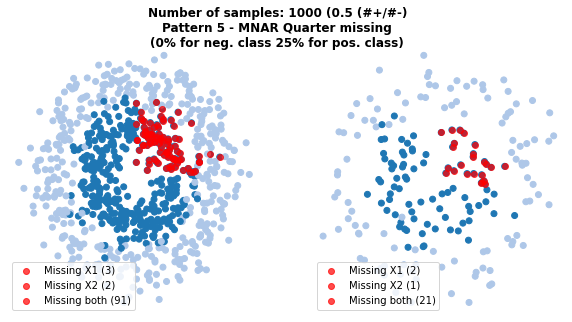

In [2]:
# Dataset default parameters
dataset_name = 'blobs'
num_samples = 1000
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES
ratio_missing_per_class = [0, 0.25]

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH
missingness_pattern = 5

# Classification default parameters
proportion_train = PROPORTION_TRAIN

verbosity=0


dataset_name = 'circles'
approach = 'ebm'
missing_data_handling='encoding'
imputation_method='without'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            debug=False, 
                            verbosity=verbosity)
dataset.split_test_train()

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, 
                                     ratio_of_missing_values=ratio_of_missing_values, 
                                     ratio_missing_per_class=ratio_missing_per_class)
dataset.plot()
plt.show()

In [3]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  approach=approach,
                  purpose='classification', 
                  previous_experiment=None, 
                  use_missing_indicator_variables=True,
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

In [4]:
exp.fit()

In [5]:
exp.predict()

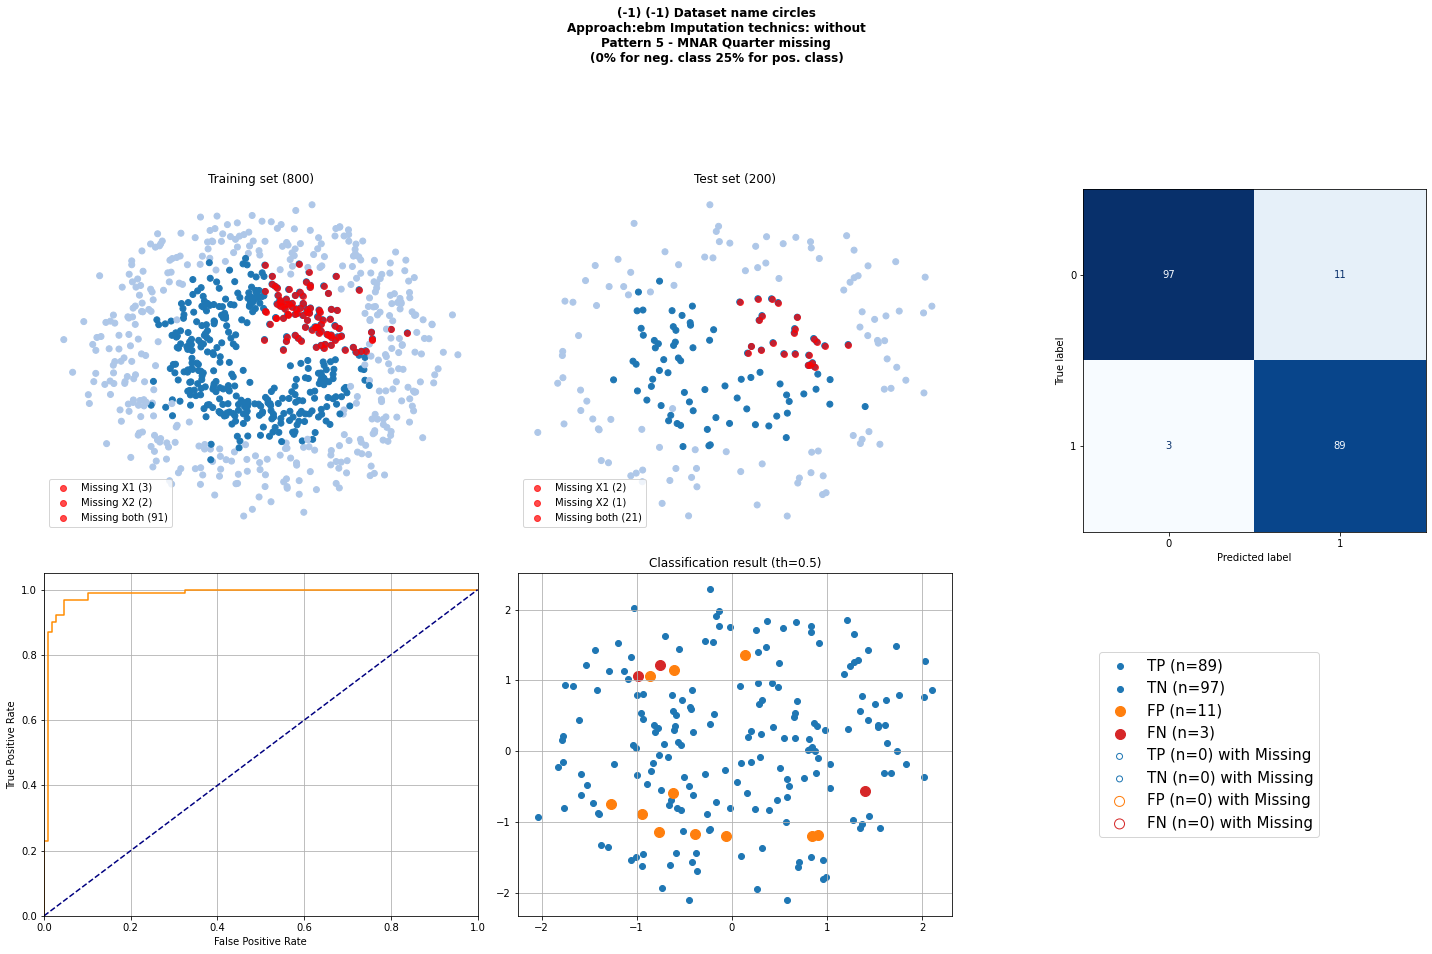

<!-- http://127.0.0.1:7001/140383839144016/ -->

In [8]:
exp.plot()

In [24]:
# Plot results
exp.approach

'ebm'

In [3]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

def format_n(x):
    return "{0:.3f}".format(x)

model = ExplainableBoostingClassifier(feature_names=['X1', 'X2'], n_jobs=-1, random_state=105)

In [8]:
from interpret import save

ImportError: cannot import name 'save' from 'interpret' (/Users/samperochon/anaconda3/envs/combinations/lib/python3.7/site-packages/interpret/__init__.py)

In [7]:
model.

SyntaxError: invalid syntax (<ipython-input-7-e5c9403477cf>, line 1)

In [4]:
model.fit(dataset.X_train, dataset.y_train)
from interpret import show

ebm_global = model.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140166686794256/ -->

In [6]:
model.predict_proba(dataset.X_train)


array([[0.9776107 , 0.0223893 ],
       [0.965937  , 0.034063  ],
       [0.98549233, 0.01450767],
       ...,
       [0.93840442, 0.06159558],
       [0.00722988, 0.99277012],
       [0.99846364, 0.00153636]])

In [11]:
ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=random_state)
scores = cross_validate(model, X, y, scoring='roc_auc', cv=ss, n_jobs=None, return_estimator=True)

record = dict()
record['model_name'] = 'EBM'
record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
record['fit_time_std'] = format_n(np.std(scores['fit_time']))
record['test_score_mean'] = format_n(np.mean(scores['test_score']))
record['test_score_std'] = format_n(np.std(scores['test_score']))
record



ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=random_state)
scores = cross_validate(model, X, y, scoring='roc_auc', cv=ss, n_jobs=None, return_estimator=True)

record = dict()
record['model_name'] = 'EBM'
record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
record['fit_time_std'] = format_n(np.std(scores['fit_time']))
record['test_score_mean'] = format_n(np.mean(scores['test_score']))
record['test_score_std'] = format_n(np.std(scores['test_score']))
record

<!-- http://127.0.0.1:7001/140433237683664/ -->

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [ ]:

model = XGBClassifier(use_label_encoder=False,
                      learning_rate=0.01,
                      verbosity=1,
                      objective='binary:logistic',
                      eval_metric='auc',
                      booster='gbtree',
                      tree_method='exact',
                      subsample=1,
                      colsample_bylevel=.8,
                      alpha=0)

model.fit(dataset.X_train, dataset.y_train)

In [149]:
df_pruned = deepcopy(df.drop_duplicates(subset=['dataset_name', 'approach', 'missing_data_handling', 'imputation_method', 'use_missing_indicator_variables', 'num_samples', 'imbalance_ratio', 'missingness_pattern', 'ratio_of_missing_values']))

#### ml.py


In [3]:
"""
Machine learning algorithms, models, training and evaluating scripts. 
-----
Durham, NC, Jun 2021
matias di martino                                 matias.di.martino.uy@gmail.com
"""

from operator import le
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import os
import plotly.express as px


class my_model_categorical(BaseEstimator, ClassifierMixin):
    """Wrap sklearn models into my own estimator, this allows my to handle some upsampling and custom operations in a more compact fashion. 
    """
    def __init__(self, method, name='ClassifierName'):
        self.name = name
        if method == 'cnb':
            from sklearn.naive_bayes import CategoricalNB
            self.model = CategoricalNB()

    def fit(self, X, y, balanced=True, batch_size=16, epochs=50, name = 'log_id'):
        """
        Train the model using X (n_samples, n_features) matrix, for the two classes
        problem. To work with imbalanced probels, balanced=True can be set, which 
        oversamples the minority class (assumed to be the positive class y=1), to 
        much the number of samples in the majority class (assumed to be the negative
        class, i.e., y=0). You can set "model_id" parameters to set where tensorboard
        logs are saved, which is useful to visualize training. 
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        """
        Oversample the minority class
        """
        if balanced:
            X,y = upsample_minority(X,y,method='smote')

        """
        Fit
        """
        self.model.fit(X, y)        
        return self
    
    def predict_proba(self, X):
        # Predict the classification score (associated with the class==1)
        y_score = self.model.predict_proba(X)[:,1]  
        return y_score
    
    def predict(self, X, th=.5):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        # Normalize the sample to match the pre-processing done at training        
        y_score = self.predict_proba(X)  # predict 
        y_pred = [1 if yy>=th else 0 for yy in y_score]
        return y_pred


class my_model(BaseEstimator, ClassifierMixin):
    """Wrap sklearn models into my own estimator, this allows my to handle some upsampling and custom operations in a more compact fashion. 
    """
    def __init__(self, method, name='ClassifierName', **kwargs):
        
        self.name = name
        self.force_all_finite = True
        self.sampling_method = 'smote'

        # Depending on the method selected, init the proper sklearn model
        if method == "knn":  # use k-nearest neighbor
            from sklearn.neighbors import KNeighborsClassifier
            self.model =  KNeighborsClassifier(n_neighbors=40, weights='uniform', **kwargs)

        if method == "lg":  # use logistic regresion
            from sklearn.linear_model import LogisticRegression
            self.model = LogisticRegression(**kwargs)

        if method == 'nb': 
            from sklearn.naive_bayes import GaussianNB
            self.model = GaussianNB(**kwargs)
            
        if method == 'xgboost':
            from xgboost import XGBClassifier
            self.model = XGBClassifier(use_label_encoder=False,
                                      learning_rate=0.01,
                                      verbosity=1,
                                      objective='binary:logistic',
                                      eval_metric='auc',
                                      booster='gbtree',
                                      tree_method='exact',
                                      subsample=1,
                                      colsample_bylevel=.8,
                                      alpha=0, 
                                      **kwargs)
            self.force_all_finite = False
            self.sampling_method = 'vanilla'

    def fit(self, X, y, balanced=True, **kwargs):
        """
        Train the model using X (n_samples, n_features) matrix, for the two classes
        problem. To work with imbalanced probels, balanced=True can be set, which 
        oversamples the minority class (assumed to be the positive class y=1), to 
        much the number of samples in the majority class (assumed to be the negative
        class, i.e., y=0). You can set "model_id" parameters to set where tensorboard
        logs are saved, which is useful to visualize training. 
        """

        if self.force_all_finite:
            X_filled = X.copy()
            X_filled[np.isnan(X_filled)] = -1
        else:
            X_filled = X


        
        # Check that X and y have correct shape
        X, y = check_X_y(X_filled, y, force_all_finite=self.force_all_finite)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        """
        Normalize the data and store the normalization parameters. 
        """
        from sklearn import preprocessing
        self.scaler = preprocessing.StandardScaler()
        self.scaler.fit(X_filled)  # fit scaler
        X_filled = self.scaler.transform(X_filled) # normalize the training data. 

        """
        Oversample the minority class
        """
        if balanced:
            X_filled,y = upsample_minority(X_filled,y,method=self.sampling_method)
        #ratio_train = float(np.sum(y == 0)) / np.sum(y==1)
        #print("Ratio after upsampling minority class: {}".format(ratio_train))

        """
        Fit
        """
        self.model.fit(X_filled, y, **kwargs)        
        return self
    
    def predict_proba(self, X):
        # Predict the classification score (associated with the class==1)
        X = self.scaler.transform(X)  # normalized input

        # Fill the values with -1 in case of algorithm not robust to missing data
        if self.force_all_finite:
            X_filled = X.copy()
            X_filled[np.isnan(X_filled)] = -1
        else:
            X_filled = X
        y_score = self.model.predict_proba(X_filled)[:,1]  
        return y_score
    
    def predict(self, X, th=.5):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        # Normalize the sample to match the pre-processing done at training        
        y_score = self.predict_proba(X)  # predict 
        y_pred = [1 if yy>=th else 0 for yy in y_score]
        return y_pred
    

def upsample_minority(X,y,method='smote'):
    # Using smote:
    if method=='smote':
        from imblearn.over_sampling import SMOTE
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)

    else:
        # Or using simple instance replication:
        # If balanced, upsamples the minority class to have a balanced training set. 
        X0 = X[y==0]
        y0 = y[y==0]
        X1 = X[y==1]
        y1 = y[y==1]

        # Upsample the minority class
        from sklearn import utils
        X1_upsample = utils.resample(X1, replace=True, n_samples=X0.shape[0])
        y1_upsample = utils.resample(y1, replace=True, n_samples=X0.shape[0])
        X = np.vstack((X0, X1_upsample))
        y = np.hstack((y0, y1_upsample))

    return X,y


def evaluate_model(model=None, X=None, y=None, threshold=.5, classes_names = ['0', '1'], num_cv=10, verbose=False, **kwargs):
    """
    Evaluate a sklearn model for the data X with ground truth labels y
    """
    from sklearn.metrics import classification_report
    from sklearn.metrics import plot_roc_curve
    from sklearn.model_selection import StratifiedKFold

    y_pred_score = -1*np.ones_like(y).astype('float32')  # init prediction scores 
    
    if num_cv>0:   # use cross-validation.
        cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=0)
        # print('Performing {} fold cross-validation.'.format(num_cv))
        for i, (train, test) in enumerate(cv.split(X, y)):
            if False and 'xgboost' in model.name:
                ratio_train = float(np.sum(y[train] == 0)) / np.sum(y[train]==1)
                model.model.scale_pos_weight = ratio_train

            if False and 'xgboost' in model.name:
                kwargs['eval_set'] = [(X[test], y[test])]

            # Fit classifier
            model.fit(X[train], y[train], balanced=True, **kwargs)
            # Predict samples on the test set
            y_pred_score[test] = model.predict_proba(X[test])

    else:  # just fit and predict the data (just for baseline, DON'T USE TO ASSES PERFORMANCE)
        model.fit(X, y, balanced= True)
        y_pred_score = model.predict_proba(X)

    """
    Plot PR and ROC curves.  
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = plot_PR_and_ROC_curves(y_true=y, y_score=y_pred_score)
    
    """
    Classification performance for a operation point.  
    """
    if verbose:
        print('For a classification threshold of {:3.2f}, the performance is:'.format(threshold))
        y_pred = y_pred_score > threshold  # Predicted binary label for the given th.
        my_classification_report(y, y_pred)
    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc


def my_classification_report(y_true, y_pred):
    """
    Print several performance metrics that are common in the context of screening and fraud detection.
    """    

    """
    First compute the TP, FP, TN and FN from which most metrics derive
    """
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    """
    Compute metrics of interest  
    """    
    print('Sample: {} positive and {} negative samples (#p/#n={:3.0f}%)'.format(tp+fn, tn+fp, 100*(tp+fn)/(tn+fp)))
    acc = (tp + tn) / (tp + tn + fp +  fn)
    print('Accuracy: {:3.1f}%'.format(100*acc))
    f1 = 2*tp / (2*tp + fp + fn)
    print('F1 score (2 PPVxTPR/(PPV+TPR)): {:3.1f}%'.format(100*f1))
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print('Matthews correlation coefficient (MCC): {:3.1f}%'.format(100*mcc))
    tpr =  tp / (tp+fn)
    print('Sensitivity, recall, hit rate, or true positive rate (TPR): {:3.1f}%'.format(100*tpr))
    tnr = tn / (tn+fp)
    print('Specificity, selectivity or true negative rate (TNR): {:3.1f}%'.format(100*tnr))
    ppv = tp / (tp+fp)
    print('Precision or positive predictive value (PPV): {:3.1f}%'.format(100*ppv))
    npv = tn / (tn+fn)
    print('Negative predictive value (NPV): {:3.1f}%'.format(100*npv))
    fnr = fn / (tp+fn)
    print('Miss rate or false negative rate (FNR): {:3.1f}%'.format(100*fnr))
    print('False discovery rate (FDR=1-PPV): {:3.1f}%'.format(100*(1-ppv)))
    print('False omission rate (FOR=1-NPV): {:3.1f}%'.format(100*(1-npv)))
    

    
    return 


def plot_PR_and_ROC_curves(y_true=None, y_score=None):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go    
    fig = make_subplots(rows=1, cols=2)
    
    ref_color = '#888E90'  # Color of reference lines
    
    # print('Model PR curve.')
    from sklearn.metrics import precision_recall_curve
    precision, recall, ths_pr = precision_recall_curve(y_true, y_score)
    
    fig.add_trace(go.Line(x=precision,y=recall, hovertext=ths_pr, name='Model PR curve'), row=1, col=1)

    # Add the iso-levels of f1
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        yy = f_score * x / (2 * x - f_score)
        fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], line=dict(color=ref_color), 
                      name='f1={:2.1f}'.format(f_score)), row=1, col=1)
    fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
    fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, ths_roc = roc_curve(y_true, y_score)

    fig.add_trace(go.Line(x=fpr,y=tpr, hovertext=ths_roc, name='ROC curve'), row=1, col=2)
    fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10), line=dict(color=ref_color)), row=1, col=2)
    fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
    fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
    fig.update_layout(title="PR AND ROC curves")

    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc


def visualize_classifier(model, xrange=[-1,1], yrange=[-1,1]):
    """This only works for 2D domains and will visualize the prediction of the 
    model in the intervals xrange yrange."""
    
    x0,x1,y0,y1 = xrange[0], xrange[1], yrange[0], yrange[1]
    xx = np.meshgrid(np.linspace(x0,x1,7), np.linspace(y0,y1,7))
    xs = xx[0]
    ys = xx[1]
    z = np.zeros_like(xs)
    h,w = z.shape
    for i in range(h):
        for j in range(w):
            batch = np.array([[xs[i,j],ys[i,j]]])
            pred = model.predict_proba(batch)
            z[i,j] = pred
            
    # Show the image 
    plt.imshow(z, origin=[x0,y0], extent=[x0,x1,y0,y1])
    plt.colorbar()
    return z


#### Start

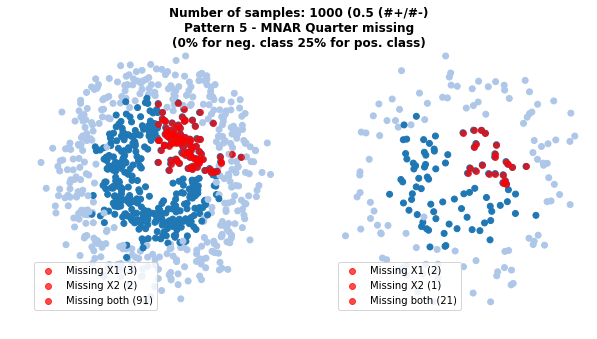

In [3]:
# Dataset default parameters
dataset_name = 'blobs'
num_samples = 1000
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES
ratio_missing_per_class = [0, 0.25]

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH
missingness_pattern = 5

# Classification default parameters
proportion_train = PROPORTION_TRAIN

verbosity=0


dataset_name = 'circles'
approach = 'nam'
missing_data_handling='encoding'
imputation_method='without'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            debug=False, 
                            verbosity=verbosity)
dataset.split_test_train()

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, 
                                     ratio_of_missing_values=ratio_of_missing_values, 
                                     ratio_missing_per_class=ratio_missing_per_class)
dataset.plot()
plt.show()

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [7]:
from xgboost import XGBClassifier
#from ../ml import visualize_classifier, my_model, plot_PR_and_ROC_curves, evaluate_model
from sklearn.model_selection import train_test_split
def test_model(X=None,y=None,model=None,df=None, num_cv=None, verbose=False, th=.5, **kwargs):
    """
    Test model and append results to the df. 
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = evaluate_model(num_cv=num_cv, 
                                                                       model=model,  
                                                                       X=X, 
                                                                       y=y, 
                                                                       threshold=th, 
                                                                       classes_names=['TD', 'ASD'],verbose=verbose, **kwargs)
    
    # Store the resutls
    df = df.append({'ExperimentName':model.name, 
                    'recall':recall, 
                    'precision':precision, 
                    'fpr':fpr, 
                    'tpr':tpr, 
                    'ths_roc': ths_roc,
                    'ths_pr': ths_pr},  ignore_index=True)
    
    return df

def plot_results_PR_and_ROC(df):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        """
        Plot the pr and roc curves for the results saved in the pandas df. 
        """
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go    

        """
        Define plot asthetics
        """
        ref_color = '#888E90'  # Color of reference lines
        colors = plt.get_cmap(name='Paired').colors  # color of each algorithm

        """
        PR curve
        """
        # (1) Initialize figures 
        fig = make_subplots(rows=1, cols=2)

        # (2) Add iso-fscore traces to PR curve
        # Add the iso-levels of f1
        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            yy = f_score * x / (2 * x - f_score)
            fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], name='f1={:2.1f}'.format(f_score), 
                        line=dict(color=ref_color)), row=1, col=1)
        fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
        fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

        # (3) Add PR curve associated to each experiment
        for i,row in df.iterrows():
            precision = row['precision']
            recall = row['recall']
            name = row['ExperimentName']
            ths_pr = row['ths_pr']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=precision,y=recall, name=name, 
                                  line=dict(color=color), hovertext=ths_pr), row=1, col=1)

        """
        Plot ROC curve
        """
        # Init plot 
        fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10),
                            line=dict(color=ref_color)), row=1, col=2)

        for i, row in df.iterrows():
            fpr = row['fpr']
            tpr = row['tpr']
            ths = row['ths_roc']
            name = row['ExperimentName']
            color = 'rgb{}'.format(colors[np.mod(i, len(colors))])
            fig.add_trace(go.Line(x=fpr,y=tpr, line=dict(color=color), hovertext=ths), row=1, col=2)
        fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
        fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
        fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
        fig.update_layout(title="PR AND ROC curves")
    return fig

def test_set_of_features(data, feats, name, df, th=.5, algos=['knn']):

    
    filter_criteria =  ' `diagnosis` in [0,1] and `age` <= 36'
    
    # Define X and y for this example    
    X  = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()

    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        print('-------------------------')
        print('{} || {} '.format(name, algo))
        print('-------------------------')
        
        for cv in [16]:
            model = my_model(method=algo, name='{}::{}-{}cv'.format(name, algo, cv), **parameters[algo])            
            df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=th)   
    return df

parameters={'knn': {}, 
            'xgboost' : {}, 
            'nb': {}}

parameters['xgboost'] = {'n_estimators' : 100,
                         'max_depth' : 2,
                         'min_child_weight' : 3,
                         'colsample_bytree' : .8, 
                         'colsample_bynode' : .8
                        }

parameters_fit={'knn': {}, 
                'xgboost' : {}}
parameters_fit['xgboost'] = {'early_stopping_rounds' : 5,
                             #'eval_set' : [(test_X, test_y)],
                             'verbose' : 0}

In [1]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False,
                      learning_rate=0.01,
                      verbosity=1,
                      objective='binary:logistic',
                      eval_metric='auc',
                      booster='gbtree',
                      tree_method='exact',
                      subsample=1,
                      colsample_bylevel=.8,
                      alpha=0)

In [ ]:
model.fit(dataset.X_train, dataset.y_train)

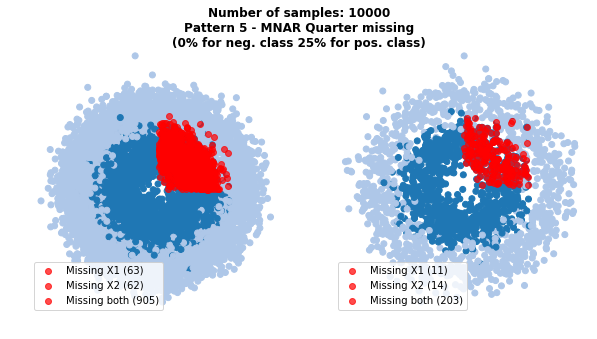

In [ ]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=verbosity, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()